Installs

In [1]:
!pip install medmnist
!pip install torch torchvision torchaudio

Libraries

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


import medmnist
from medmnist import INFO, Evaluator

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.4.1
device: cpu


Initializations

In [4]:
data_flag = 'chestmnist'
download = True

img_size = 28
batch_size = 257
num_classes = 4

# Model
z_size = 256
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# class_list = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema', 'emphysema', 'fibrosis', 'pleural', 'hernia']

class_list = ['cardiomegaly', 'consolidation', 'emphysema', 'pleural']
class_num = len(class_list)

# Training
epochs = 200  # Train epochs
g_learning_rate = 1e-4
d_learning_rate = 1e-4

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Define the labels you want to keep
target_conditions = ['cardiomegaly', 'consolidation', 'emphysema', 'pleural']

# Mapping conditions to their respective indices in the one-hot encoded label array
condition_to_index = {
    'atelectasis': 0,
    'cardiomegaly': 1,
    'effusion': 2,
    'infiltration': 3,
    'mass': 4,
    'nodule': 5,
    'pneumonia': 6,
    'pneumothorax': 7,
    'consolidation': 8,
    'edema': 9,
    'emphysema': 10,
    'fibrosis': 11,
    'pleural': 12,
    'hernia': 13
}

# Get the indices for the target conditions
target_indices = [condition_to_index[condition] for condition in target_conditions]

# Load the original datasets
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Filter the train dataset to include only the target conditions
filtered_train_data = [
    (image, labels) for image, labels in train_dataset 
    if any(labels[index] == 1 for index in target_indices)  # Check if any target condition is present
]

# Filter the test dataset similarly
filtered_test_data = [
    (image, labels) for image, labels in test_dataset 
    if any(labels[index] == 1 for index in target_indices)  # Check if any target condition is present
]

# Debugging: Print how many entries are left after filtering
print(f"Number of filtered train data entries: {len(filtered_train_data)}")
print(f"Number of filtered test data entries: {len(filtered_test_data)}")

# Encapsulate the filtered data into DataLoader
train_loader = data.DataLoader(dataset=filtered_train_data, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=filtered_train_data, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=filtered_test_data, batch_size=2*batch_size, shuffle=False)

Using downloaded and verified file: /Users/sameehaafr/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/sameehaafr/.medmnist/chestmnist.npz
Number of filtered train data entries: 8701
Number of filtered test data entries: 2618


In [6]:
target_indices = [condition_to_index[condition] for condition in target_conditions]
print(target_indices)

[1, 8, 10, 12]


Preprocessing/Data Loading

In [7]:
# # preprocessing
# data_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# # load the data
# train_dataset = DataClass(split='train', transform=data_transform, download=download)
# test_dataset = DataClass(split='test', transform=data_transform, download=download)

# pil_dataset = DataClass(split='train', download=download)

# # encapsulate data into dataloader form
# train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*batch_size, shuffle=False)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

In [8]:
# print(filtered_train_data)
# print("===================")
# print(filtered_test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


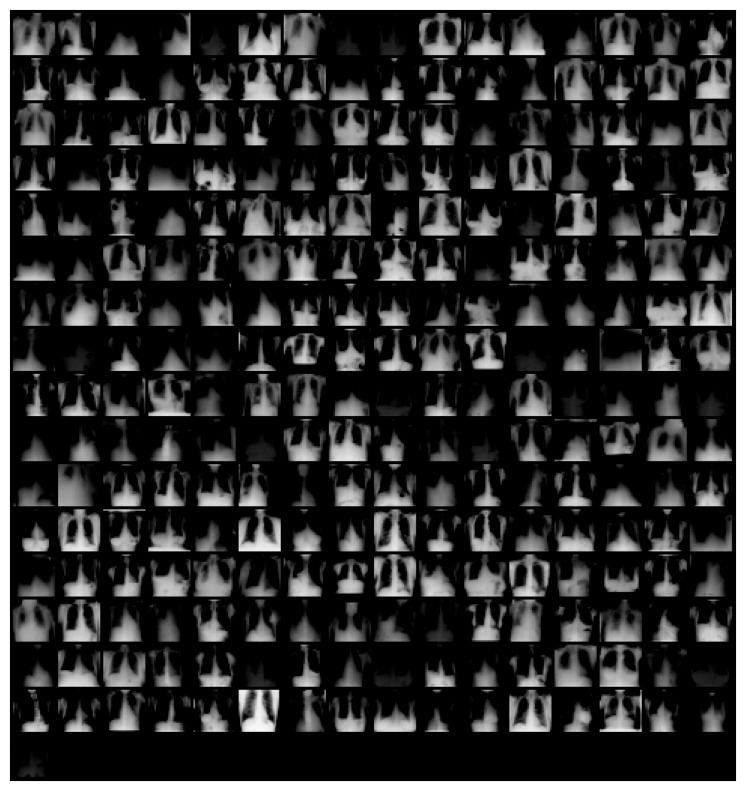

In [9]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

Generator

In [10]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size

        self.label_emb = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):

        # Reshape z
        z = z.view(-1, self.z_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([z, c], 1)

        # Generator out
        out = self.model(x)

        return out.view(-1, self.img_size, self.img_size)

Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size

        input_size = (self.img_size * self.img_size) + class_num

        self.model = nn.Sequential(
            nn.Linear((self.img_size * self.img_size) + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
        self.model.to(device)

    def forward(self, x, labels):


        # Reshape fake image
        x = x.view(x.size(0), -1)  # Flatten image

        # One-hot vector to embedding vector
        c = self.label_emb(labels).view(labels.size(0), -1)

        # Calculate total input size: flattened image size + embedding size
        total_input_size = x.size(1) + c.size(1)

        # Create a new linear layer with the correct input size
        self.model[0] = nn.Linear(total_input_size, 1024)

        # Concat image & label
        x = torch.cat([x, c], 1)

        # Discriminator out
        out = self.model(x)

        return out.squeeze()

In [12]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

Loss Functions and Optimizers

In [13]:
# Loss function
criterion = nn.BCELoss()
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

Training

In [14]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):

    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Discriminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data

In [15]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):

    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    # Sum two losses
    d_loss = real_loss + fake_loss

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data

In [16]:
def calculate_discriminator_accuracy(discriminator, real_images, labels):
    real_validity = discriminator(real_images, labels)
    real_accuracy = torch.mean((real_validity > 0.5).float())
    return real_accuracy.item()

Training Loop

Starting epoch 1...
g_loss: 0.7254467606544495, d_loss: 1.3574597835540771


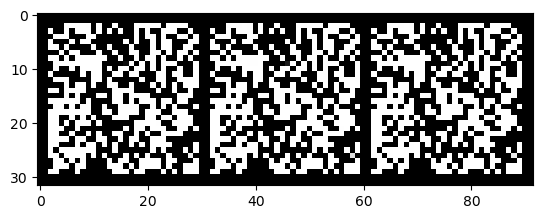

Starting epoch 2...
g_loss: 0.9995278716087341, d_loss: 1.240063190460205


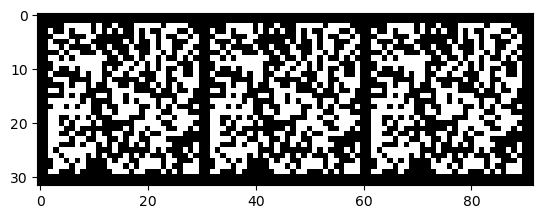

Starting epoch 3...
g_loss: 1.2141306400299072, d_loss: 1.2419567108154297


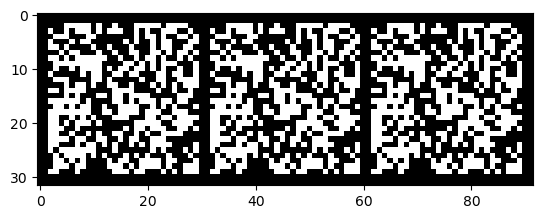

Starting epoch 4...
g_loss: 1.2786973714828491, d_loss: 1.2579784393310547


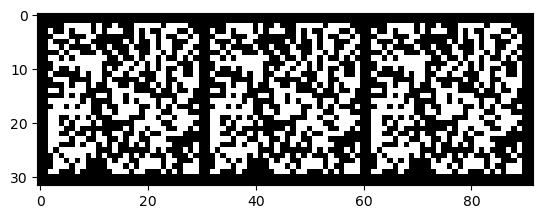

Starting epoch 5...
g_loss: 1.2416263818740845, d_loss: 1.1427037715911865


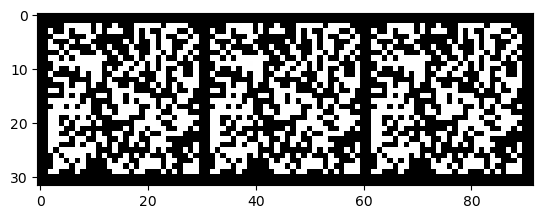

Starting epoch 6...
g_loss: 1.1008098125457764, d_loss: 1.1529030799865723


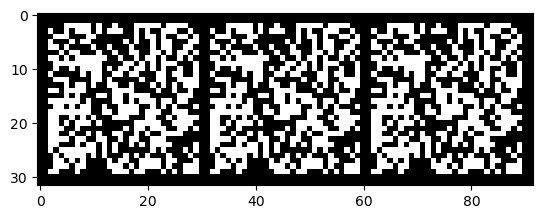

Starting epoch 7...
g_loss: 1.4223986864089966, d_loss: 1.1882755756378174


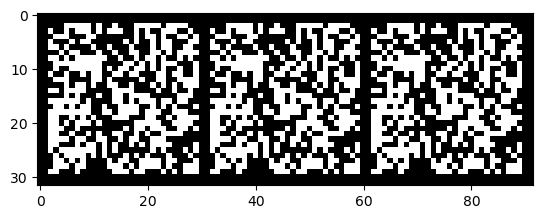

Starting epoch 8...
g_loss: 1.155646800994873, d_loss: 1.0617542266845703


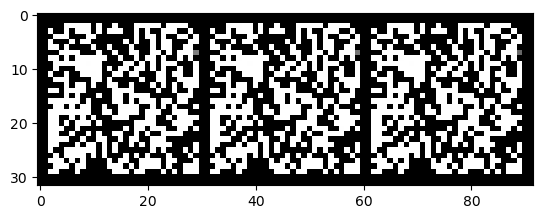

Starting epoch 9...
g_loss: 1.1634405851364136, d_loss: 1.2458857297897339


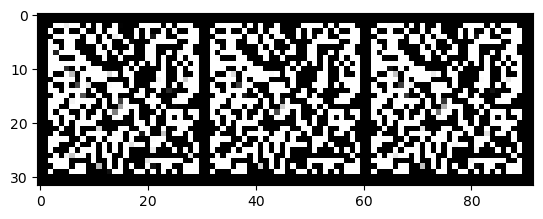

Starting epoch 10...
g_loss: 0.5339781641960144, d_loss: 1.5385022163391113


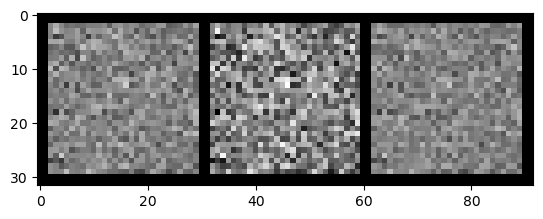

Starting epoch 11...
g_loss: 0.42466244101524353, d_loss: 1.4108614921569824


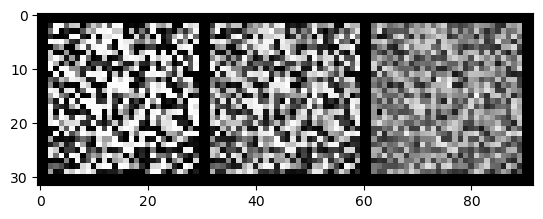

Starting epoch 12...
g_loss: 0.5559976696968079, d_loss: 1.5010430812835693


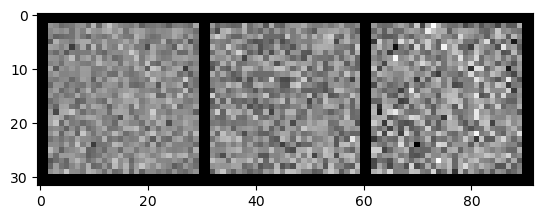

Starting epoch 13...
g_loss: 0.5115046501159668, d_loss: 1.448476791381836


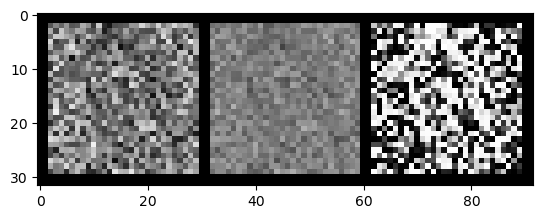

Starting epoch 14...
g_loss: 0.630833089351654, d_loss: 1.484493613243103


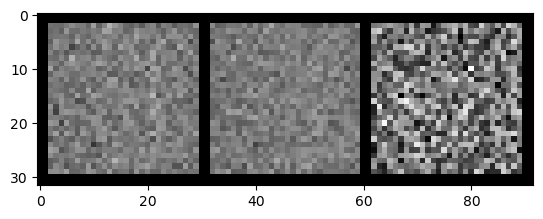

Starting epoch 15...
g_loss: 0.5733929872512817, d_loss: 1.3921446800231934


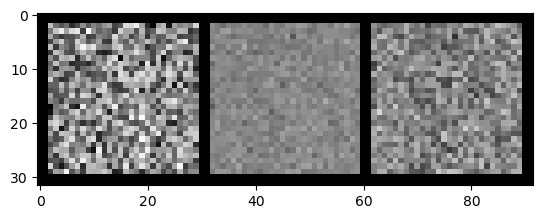

Starting epoch 16...
g_loss: 0.6536616683006287, d_loss: 1.3306734561920166


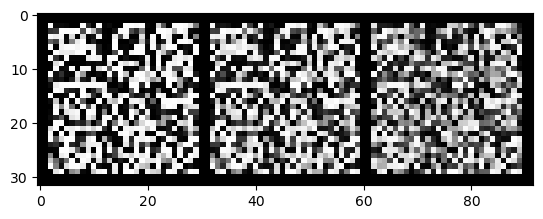

Starting epoch 17...
g_loss: 0.6187788844108582, d_loss: 1.4500735998153687


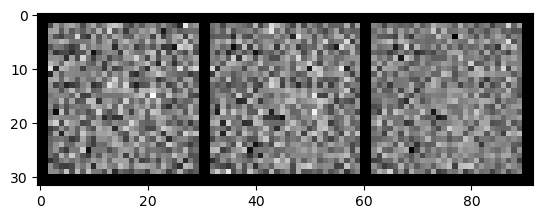

Starting epoch 18...
g_loss: 0.6089090704917908, d_loss: 1.3979803323745728


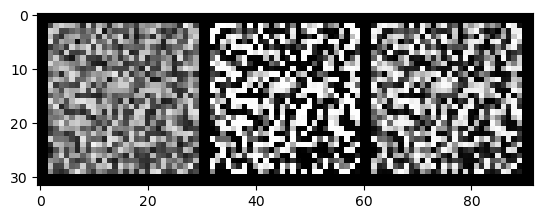

Starting epoch 19...
g_loss: 0.6360093951225281, d_loss: 1.4039373397827148


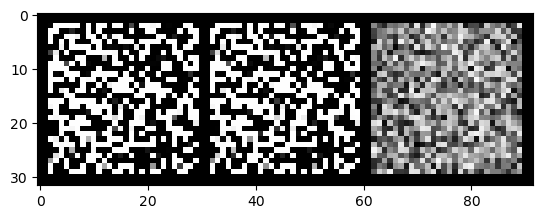

Starting epoch 20...
g_loss: 0.6279463768005371, d_loss: 1.4200260639190674


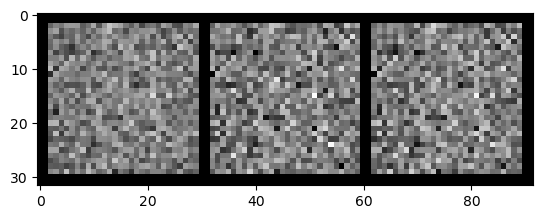

Starting epoch 21...
g_loss: 0.6110469102859497, d_loss: 1.3725866079330444


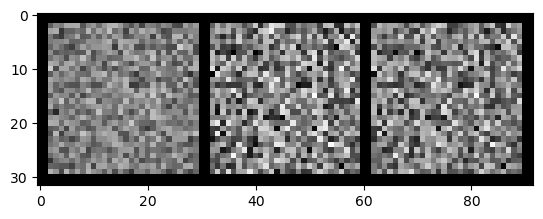

Starting epoch 22...
g_loss: 0.6569552421569824, d_loss: 1.3957908153533936


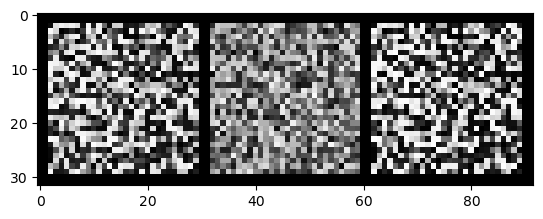

Starting epoch 23...
g_loss: 0.6732575297355652, d_loss: 1.3954997062683105


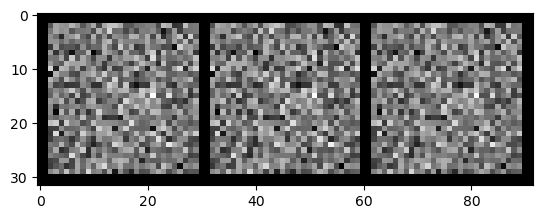

Starting epoch 24...
g_loss: 0.6498731374740601, d_loss: 1.3951687812805176


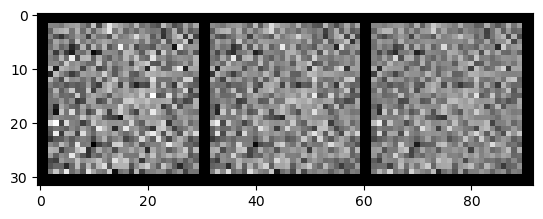

Starting epoch 25...
g_loss: 0.5971236228942871, d_loss: 1.3788747787475586


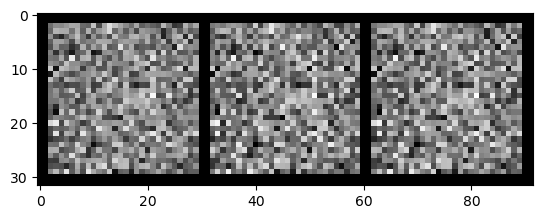

Starting epoch 26...
g_loss: 0.640219509601593, d_loss: 1.404200553894043


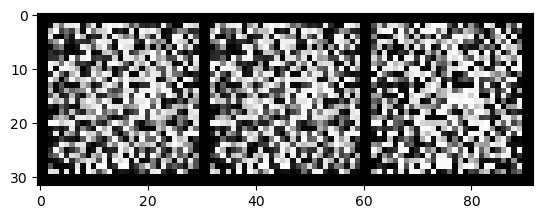

Starting epoch 27...
g_loss: 0.7492713928222656, d_loss: 1.381069540977478


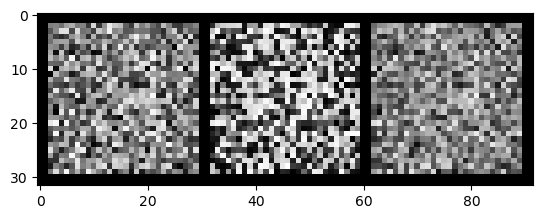

Starting epoch 28...
g_loss: 0.667312502861023, d_loss: 1.4007571935653687


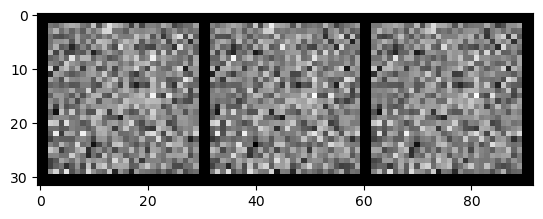

Starting epoch 29...
g_loss: 0.6486721634864807, d_loss: 1.364903450012207


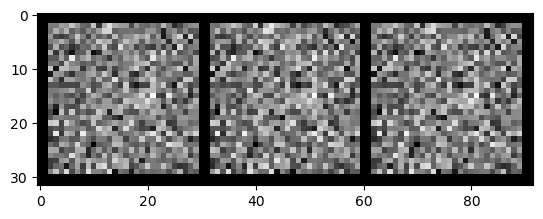

Starting epoch 30...
g_loss: 0.6065809726715088, d_loss: 1.3951290845870972


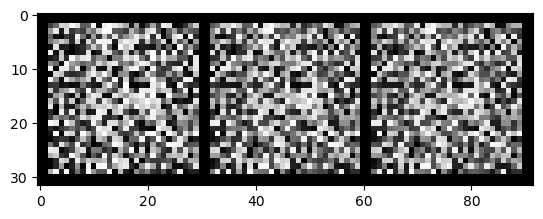

Starting epoch 31...
g_loss: 0.7333257794380188, d_loss: 1.3422513008117676


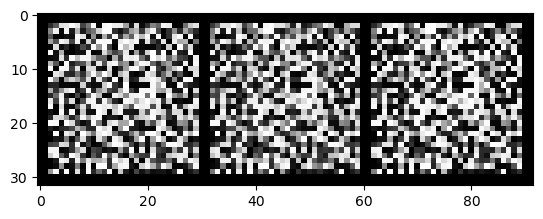

Starting epoch 32...
g_loss: 0.7447577118873596, d_loss: 1.4024794101715088


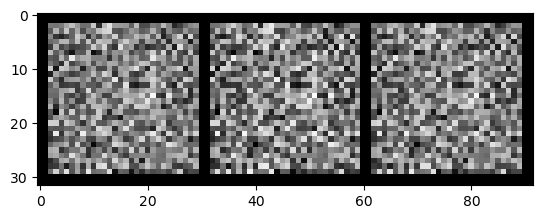

Starting epoch 33...
g_loss: 0.6732987761497498, d_loss: 1.3975698947906494


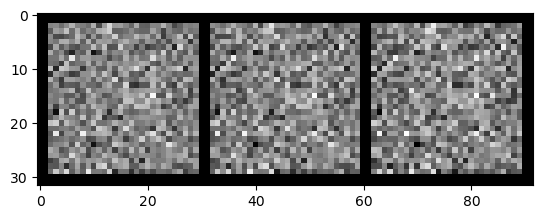

Starting epoch 34...
g_loss: 0.6339629292488098, d_loss: 1.3778536319732666


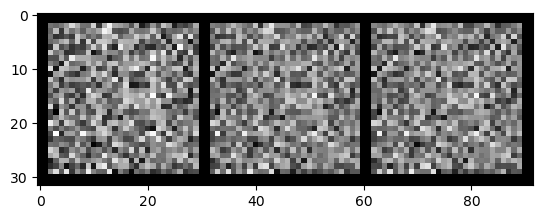

Starting epoch 35...
g_loss: 0.6165114045143127, d_loss: 1.4059758186340332


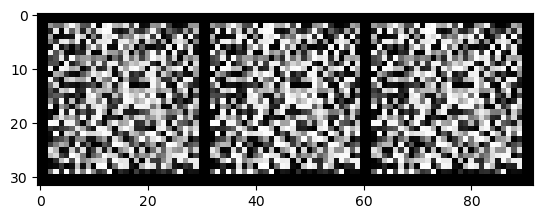

Starting epoch 36...
g_loss: 0.7242324352264404, d_loss: 1.3877873420715332


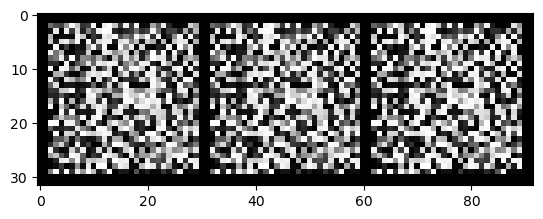

Starting epoch 37...
g_loss: 0.6925537586212158, d_loss: 1.3968727588653564


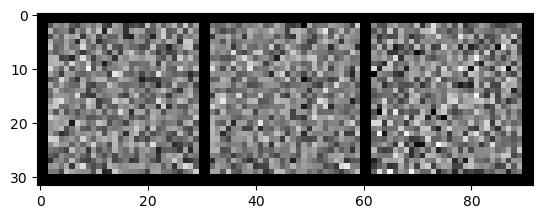

Starting epoch 38...
g_loss: 0.6685201525688171, d_loss: 1.3788585662841797


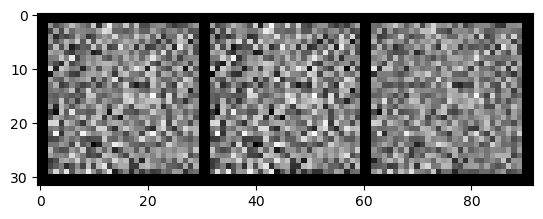

Starting epoch 39...
g_loss: 0.6363285183906555, d_loss: 1.388481855392456


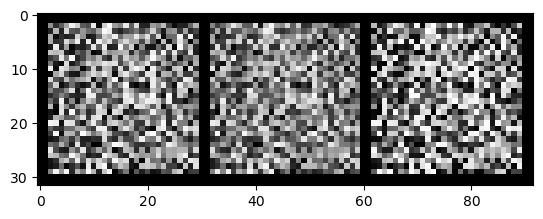

Starting epoch 40...
g_loss: 0.7361702919006348, d_loss: 1.364691972732544


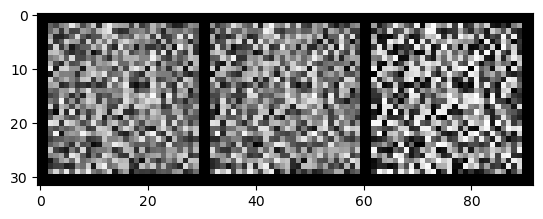

Starting epoch 41...
g_loss: 0.7013751268386841, d_loss: 1.4030828475952148


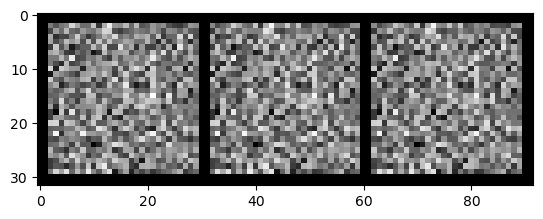

Starting epoch 42...
g_loss: 0.6808243989944458, d_loss: 1.3572537899017334


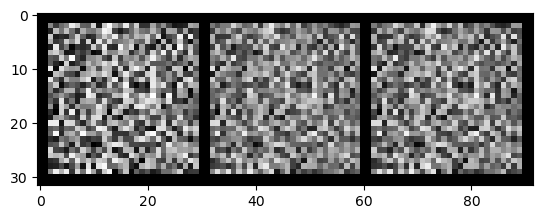

Starting epoch 43...
g_loss: 0.6492398977279663, d_loss: 1.4043976068496704


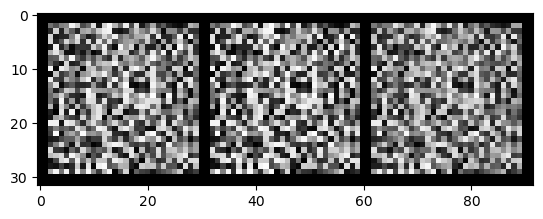

Starting epoch 44...
g_loss: 0.70365971326828, d_loss: 1.3702454566955566


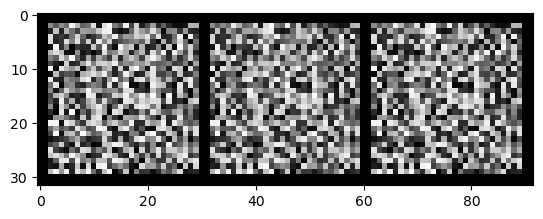

Starting epoch 45...
g_loss: 0.7153278589248657, d_loss: 1.3932346105575562


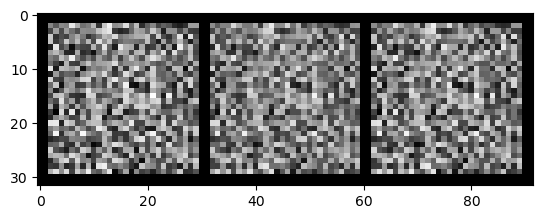

Starting epoch 46...
g_loss: 0.6856018900871277, d_loss: 1.4151862859725952


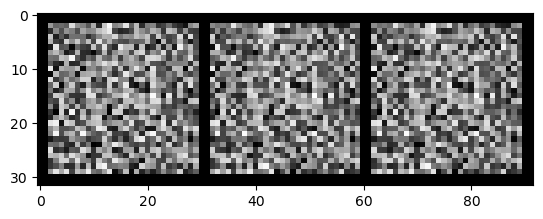

Starting epoch 47...
g_loss: 0.6734946966171265, d_loss: 1.375520944595337


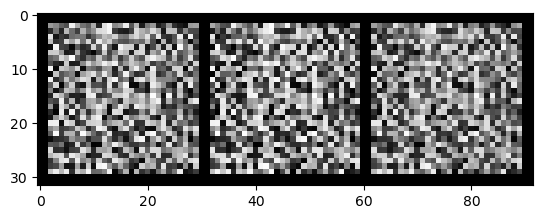

Starting epoch 48...
g_loss: 0.6823086738586426, d_loss: 1.39018714427948


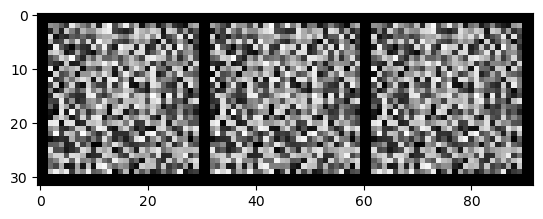

Starting epoch 49...
g_loss: 0.6601031422615051, d_loss: 1.396791934967041


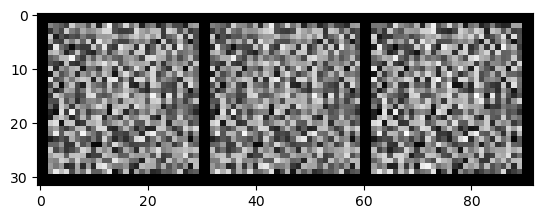

Starting epoch 50...
g_loss: 0.6713836789131165, d_loss: 1.3592766523361206


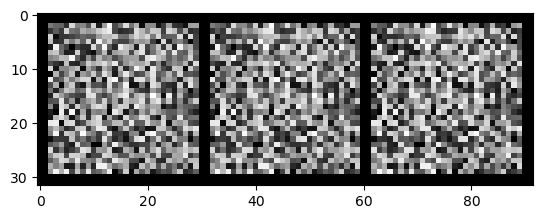

Starting epoch 51...
g_loss: 0.6472005248069763, d_loss: 1.3967440128326416


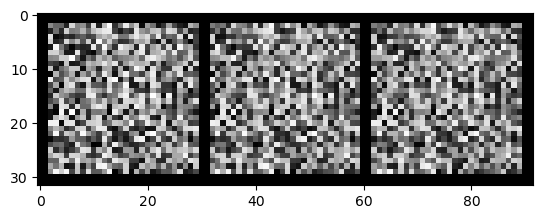

Starting epoch 52...
g_loss: 0.7386403679847717, d_loss: 1.3929319381713867


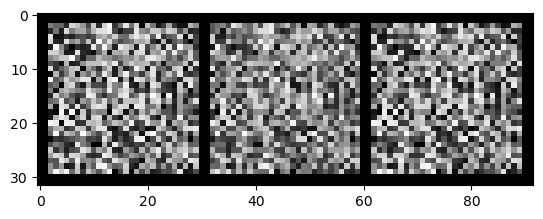

Starting epoch 53...
g_loss: 0.7047133445739746, d_loss: 1.3452632427215576


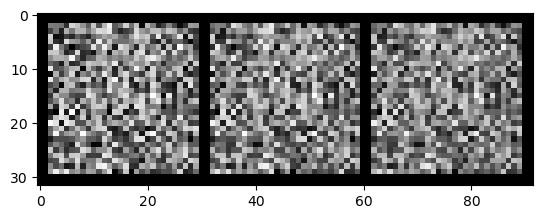

Starting epoch 54...
g_loss: 0.6788261532783508, d_loss: 1.394425392150879


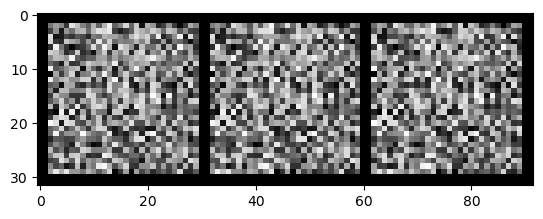

Starting epoch 55...
g_loss: 0.648748517036438, d_loss: 1.3848798274993896


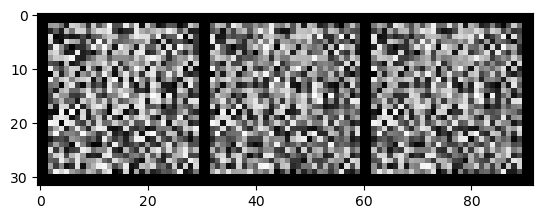

Starting epoch 56...
g_loss: 0.6848352551460266, d_loss: 1.4395787715911865


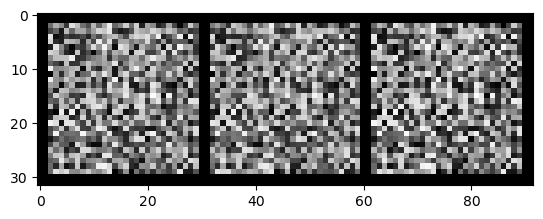

Starting epoch 57...
g_loss: 0.6995253562927246, d_loss: 1.410756230354309


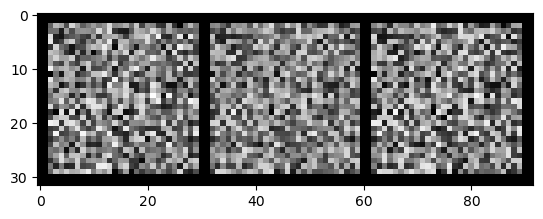

Starting epoch 58...
g_loss: 0.6895936131477356, d_loss: 1.3905949592590332


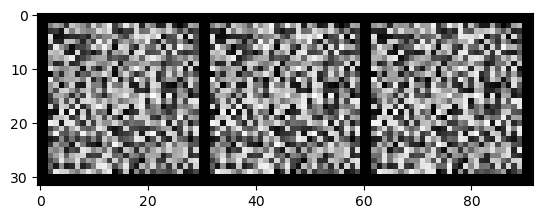

Starting epoch 59...
g_loss: 0.6989414691925049, d_loss: 1.3937450647354126


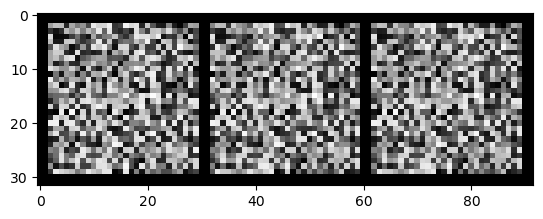

Starting epoch 60...
g_loss: 0.6999907493591309, d_loss: 1.394195318222046


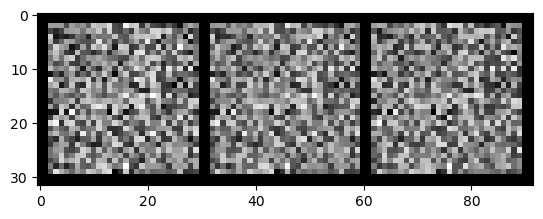

Starting epoch 61...
g_loss: 0.6794441342353821, d_loss: 1.3750187158584595


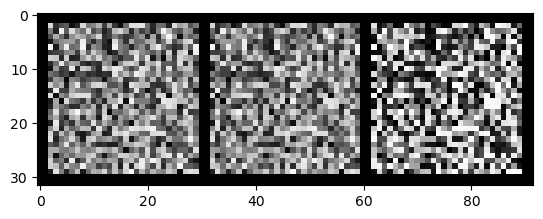

Starting epoch 62...
g_loss: 0.6920811533927917, d_loss: 1.4122726917266846


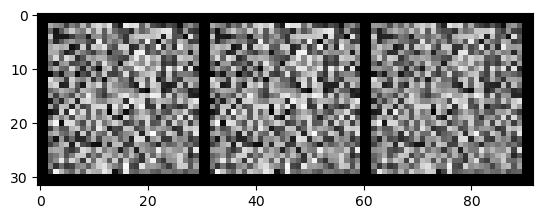

Starting epoch 63...
g_loss: 0.6285669803619385, d_loss: 1.405911922454834


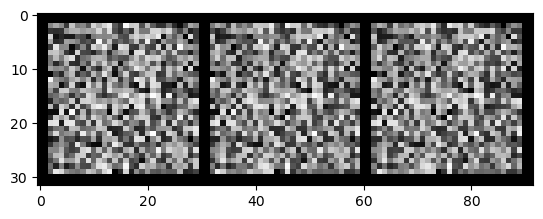

Starting epoch 64...
g_loss: 0.659896969795227, d_loss: 1.3545613288879395


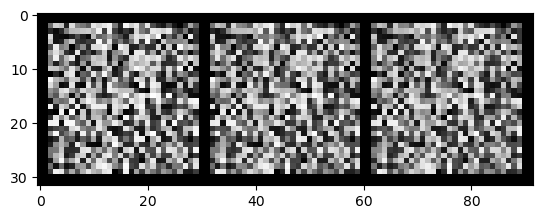

Starting epoch 65...
g_loss: 0.7026620507240295, d_loss: 1.3786182403564453


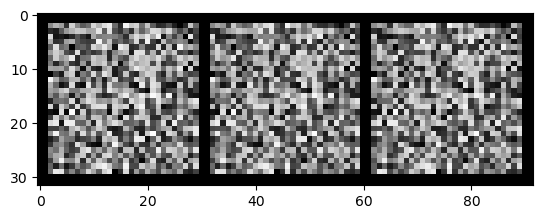

Starting epoch 66...
g_loss: 0.6864576935768127, d_loss: 1.3813896179199219


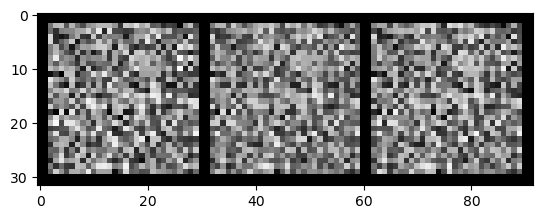

Starting epoch 67...
g_loss: 0.66804438829422, d_loss: 1.4057579040527344


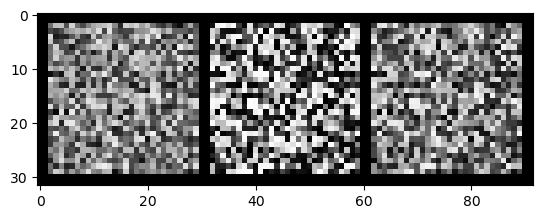

Starting epoch 68...
g_loss: 0.7082113027572632, d_loss: 1.3774361610412598


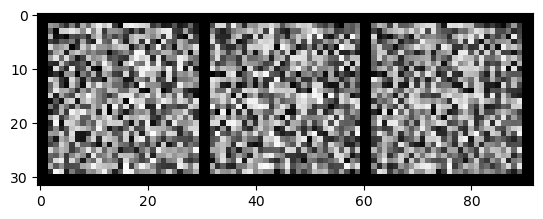

Starting epoch 69...
g_loss: 0.6880338788032532, d_loss: 1.4044233560562134


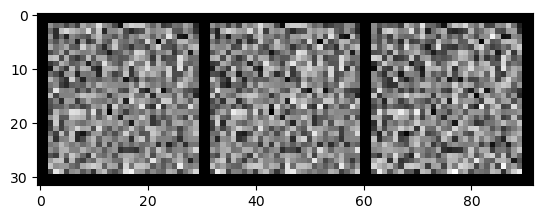

Starting epoch 70...
g_loss: 0.7057073712348938, d_loss: 1.405461072921753


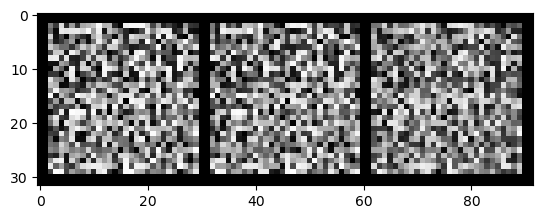

Starting epoch 71...
g_loss: 0.7482579946517944, d_loss: 1.3532341718673706


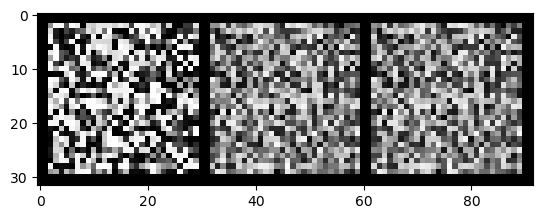

Starting epoch 72...
g_loss: 0.7048280239105225, d_loss: 1.3867908716201782


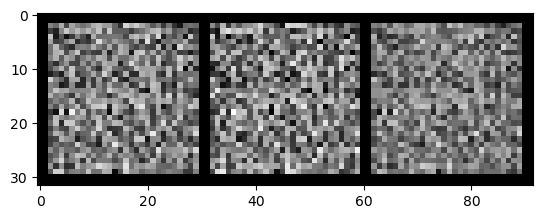

Starting epoch 73...
g_loss: 0.687886655330658, d_loss: 1.3613072633743286


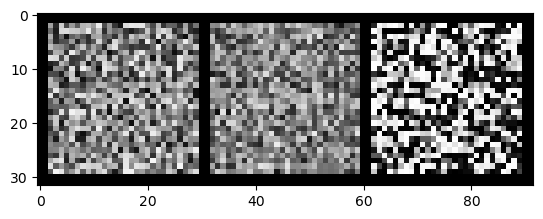

Starting epoch 74...
g_loss: 0.6828332543373108, d_loss: 1.3632314205169678


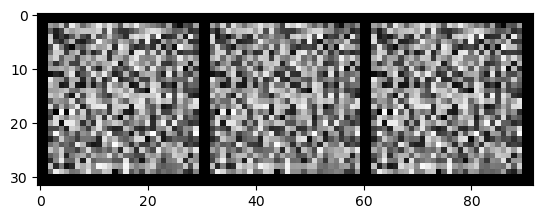

Starting epoch 75...
g_loss: 0.6855596899986267, d_loss: 1.3807443380355835


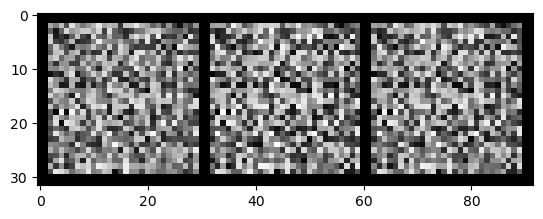

Starting epoch 76...
g_loss: 0.6942747831344604, d_loss: 1.3430739641189575


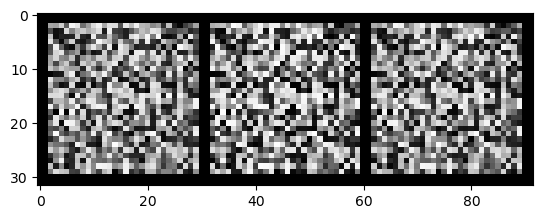

Starting epoch 77...
g_loss: 0.7122765779495239, d_loss: 1.3861212730407715


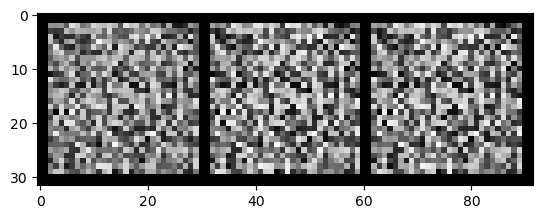

Starting epoch 78...
g_loss: 0.6732587218284607, d_loss: 1.4190800189971924


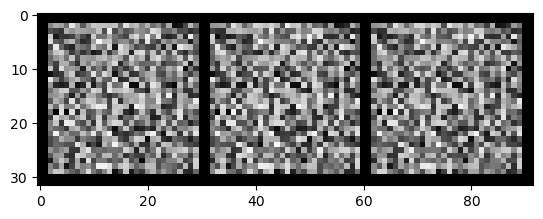

Starting epoch 79...
g_loss: 0.6670634150505066, d_loss: 1.3875491619110107


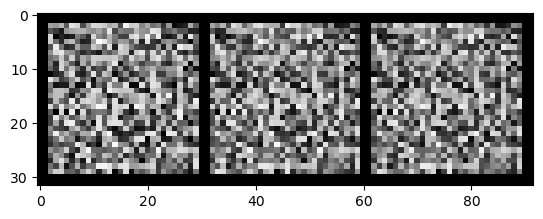

Starting epoch 80...
g_loss: 0.6818954944610596, d_loss: 1.390626072883606


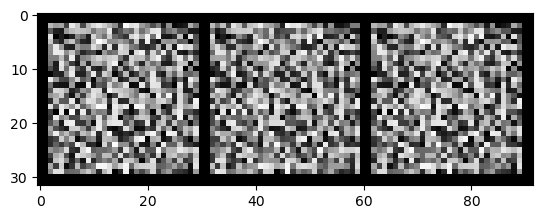

Starting epoch 81...
g_loss: 0.6781955361366272, d_loss: 1.3378612995147705


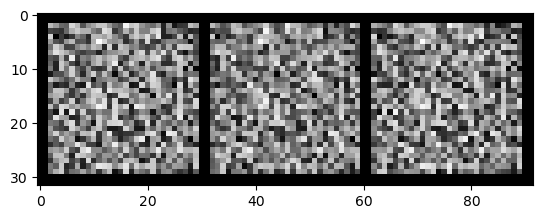

Starting epoch 82...
g_loss: 0.6595472693443298, d_loss: 1.4088726043701172


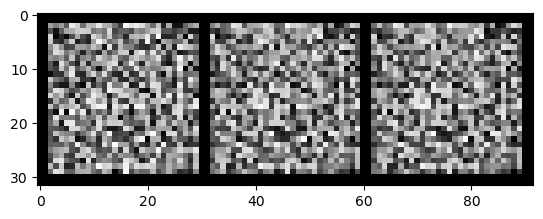

Starting epoch 83...
g_loss: 0.6966317296028137, d_loss: 1.4066476821899414


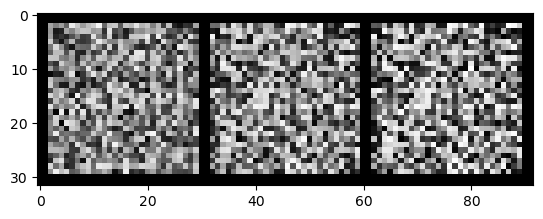

Starting epoch 84...
g_loss: 0.6913381218910217, d_loss: 1.4133381843566895


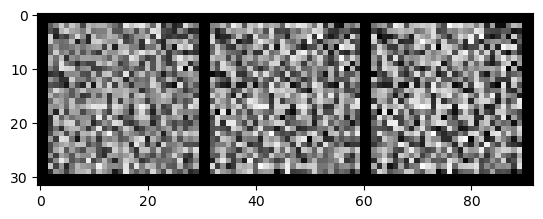

Starting epoch 85...
g_loss: 0.6784777641296387, d_loss: 1.3595410585403442


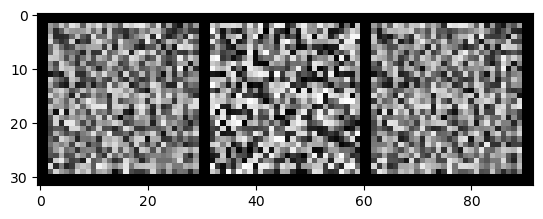

Starting epoch 86...
g_loss: 0.6738324165344238, d_loss: 1.3549339771270752


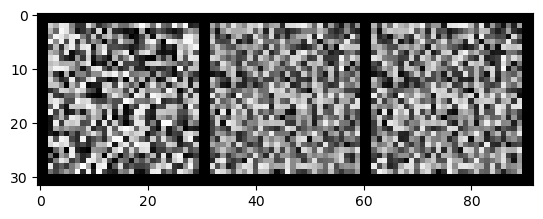

Starting epoch 87...
g_loss: 0.7041696906089783, d_loss: 1.3805322647094727


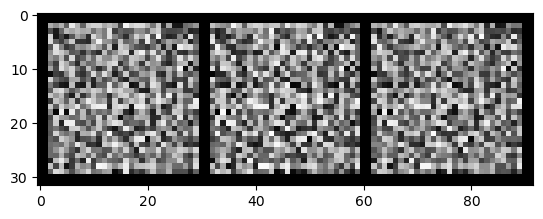

Starting epoch 88...
g_loss: 0.6895583271980286, d_loss: 1.379143238067627


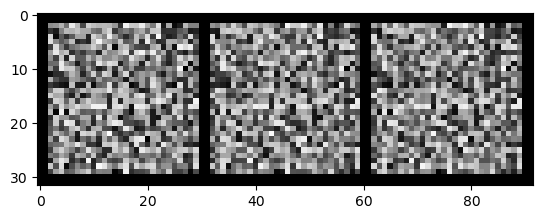

Starting epoch 89...
g_loss: 0.7056087851524353, d_loss: 1.4073084592819214


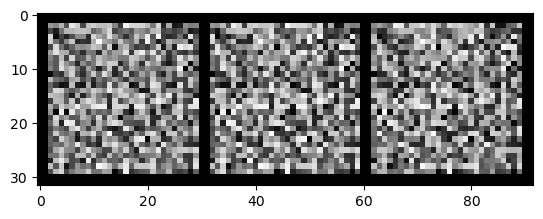

Starting epoch 90...
g_loss: 0.6705438494682312, d_loss: 1.3935680389404297


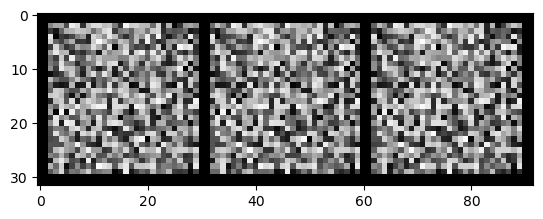

Starting epoch 91...
g_loss: 0.7033863067626953, d_loss: 1.3661795854568481


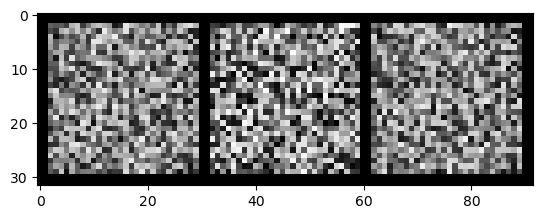

Starting epoch 92...
g_loss: 0.6823130249977112, d_loss: 1.4126369953155518


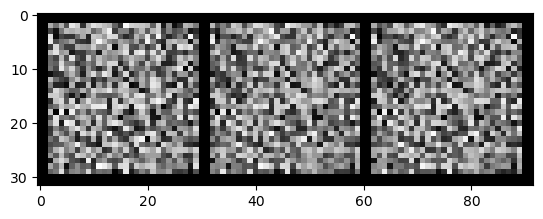

Starting epoch 93...
g_loss: 0.6746433973312378, d_loss: 1.3941888809204102


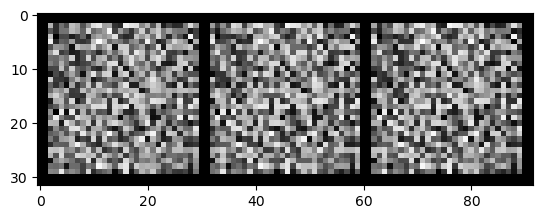

Starting epoch 94...
g_loss: 0.6685678362846375, d_loss: 1.3766852617263794


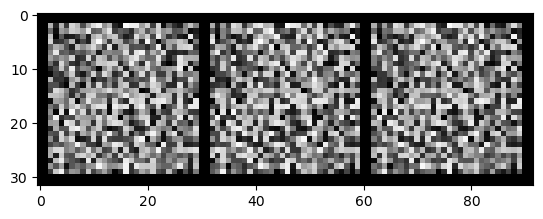

Starting epoch 95...
g_loss: 0.6688380837440491, d_loss: 1.402212381362915


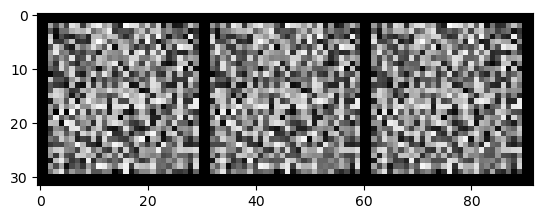

Starting epoch 96...
g_loss: 0.6907517910003662, d_loss: 1.3774912357330322


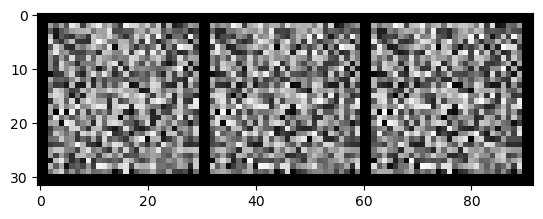

Starting epoch 97...
g_loss: 0.6717116832733154, d_loss: 1.3895457983016968


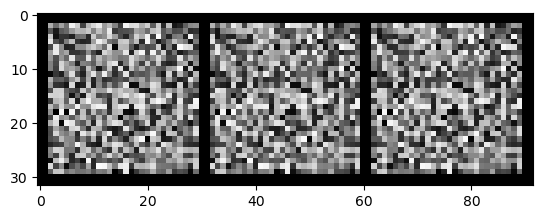

Starting epoch 98...
g_loss: 0.6884008646011353, d_loss: 1.3629612922668457


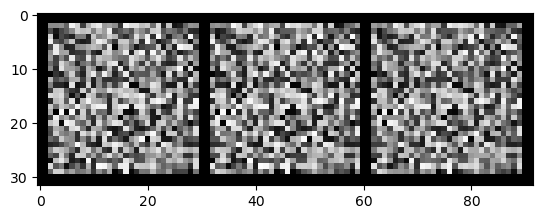

Starting epoch 99...
g_loss: 0.6783697009086609, d_loss: 1.3826271295547485


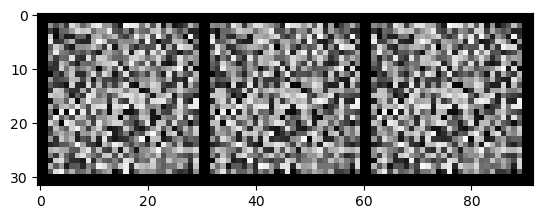

Starting epoch 100...
g_loss: 0.6821979284286499, d_loss: 1.3710479736328125


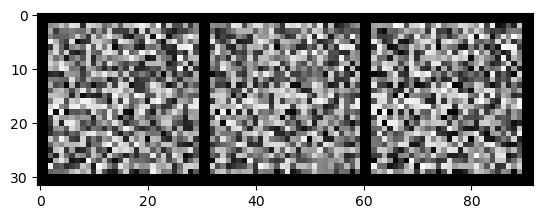

Starting epoch 101...
g_loss: 0.6839184761047363, d_loss: 1.4052929878234863


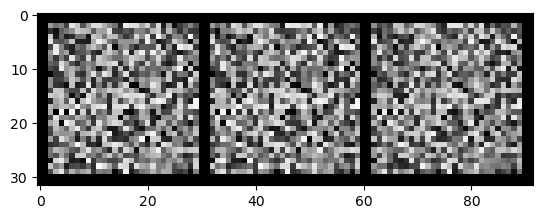

Starting epoch 102...
g_loss: 0.6880913972854614, d_loss: 1.380903959274292


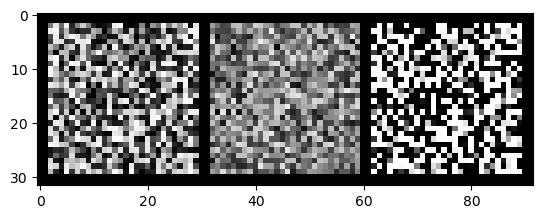

Starting epoch 103...
g_loss: 0.6876963973045349, d_loss: 1.427518367767334


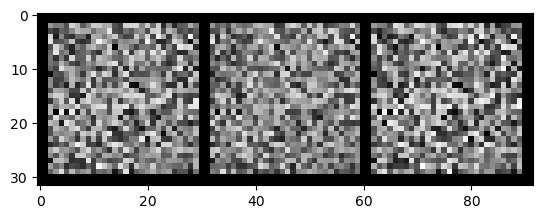

Starting epoch 104...
g_loss: 0.6715846657752991, d_loss: 1.3820116519927979


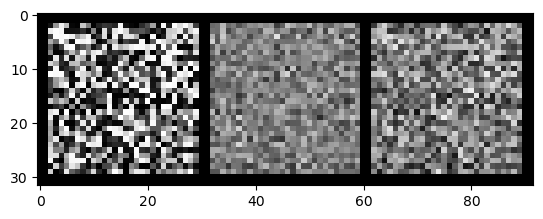

Starting epoch 105...
g_loss: 0.6940843462944031, d_loss: 1.373781681060791


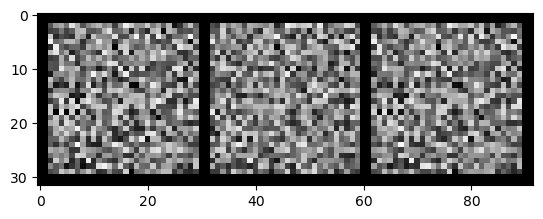

Starting epoch 106...
g_loss: 0.6796477437019348, d_loss: 1.3877307176589966


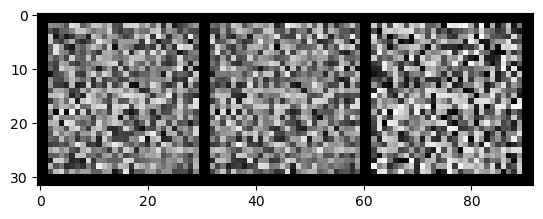

Starting epoch 107...
g_loss: 0.6940919160842896, d_loss: 1.3961894512176514


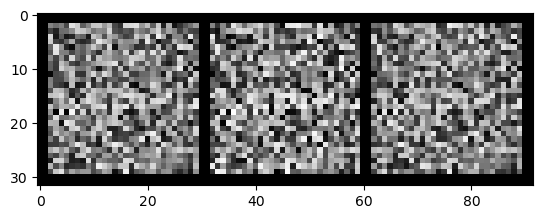

Starting epoch 108...
g_loss: 0.6824826002120972, d_loss: 1.3812185525894165


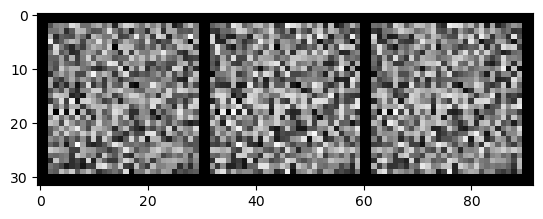

Starting epoch 109...
g_loss: 0.6786119937896729, d_loss: 1.3877136707305908


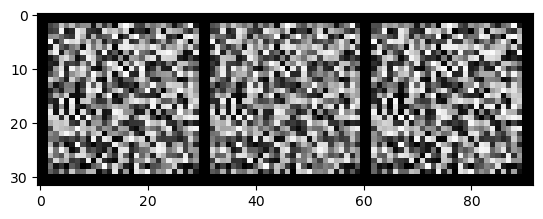

Starting epoch 110...
g_loss: 0.7394730448722839, d_loss: 1.398909568786621


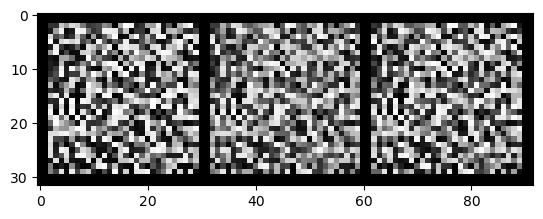

Starting epoch 111...
g_loss: 0.7092068195343018, d_loss: 1.4059019088745117


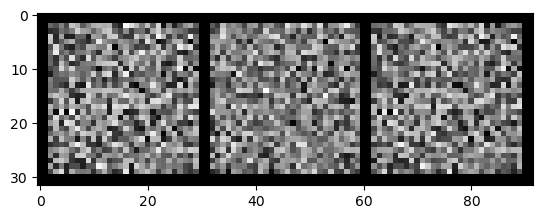

Starting epoch 112...
g_loss: 0.6694933176040649, d_loss: 1.3922033309936523


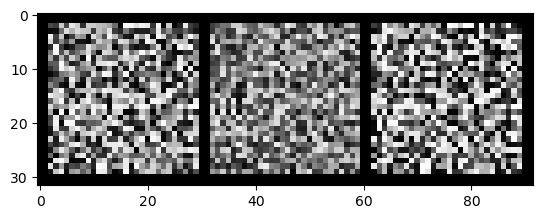

Starting epoch 113...
g_loss: 0.6837189197540283, d_loss: 1.3733689785003662


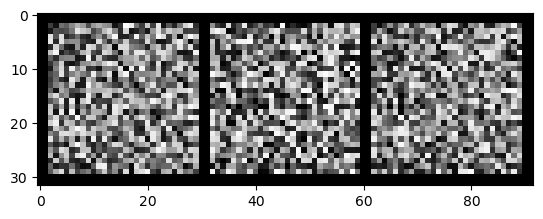

Starting epoch 114...
g_loss: 0.6990811228752136, d_loss: 1.4090299606323242


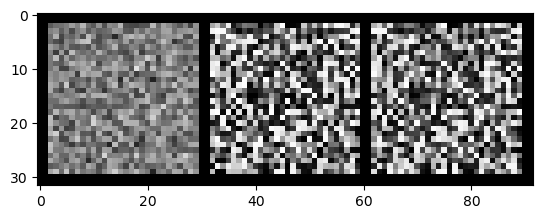

Starting epoch 115...
g_loss: 0.6845591068267822, d_loss: 1.3844536542892456


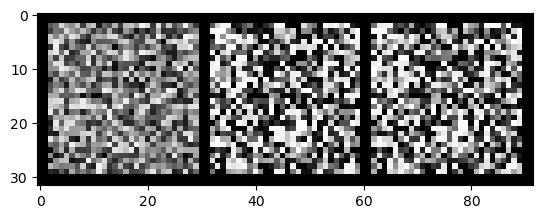

Starting epoch 116...
g_loss: 0.7046816349029541, d_loss: 1.3913003206253052


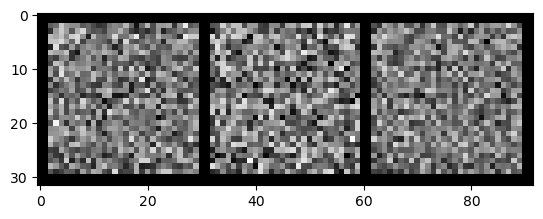

Starting epoch 117...
g_loss: 0.6899107098579407, d_loss: 1.3902292251586914


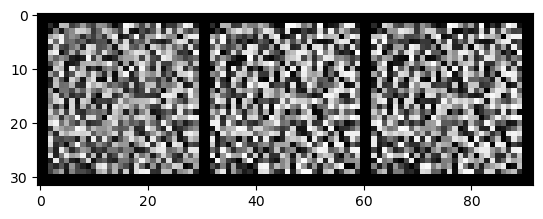

Starting epoch 118...
g_loss: 0.7082844972610474, d_loss: 1.4018468856811523


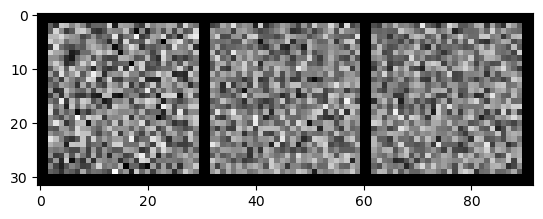

Starting epoch 119...
g_loss: 0.7187451124191284, d_loss: 1.4128408432006836


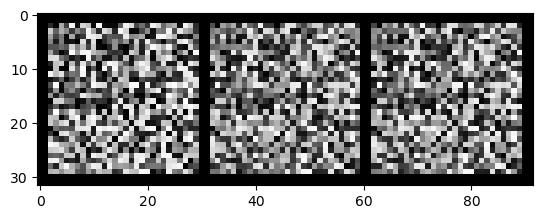

Starting epoch 120...
g_loss: 0.6996960639953613, d_loss: 1.392728328704834


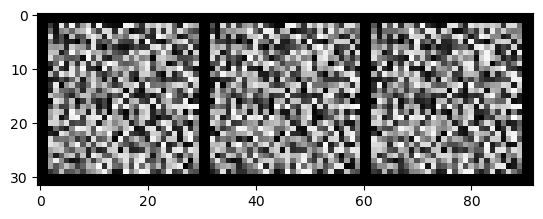

Starting epoch 121...
g_loss: 0.6957525610923767, d_loss: 1.3945960998535156


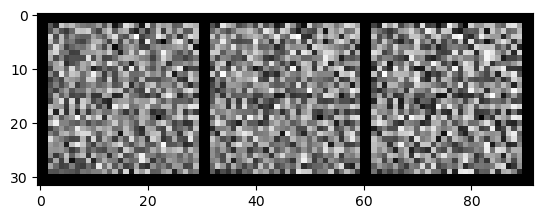

Starting epoch 122...
g_loss: 0.6847004294395447, d_loss: 1.3732024431228638


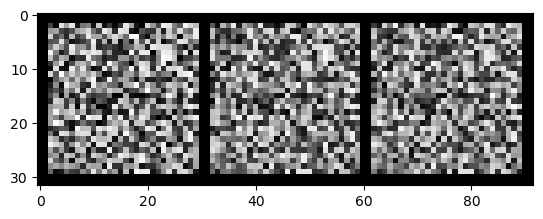

Starting epoch 123...
g_loss: 0.6986450552940369, d_loss: 1.3835442066192627


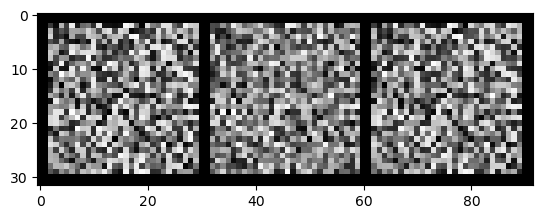

Starting epoch 124...
g_loss: 0.7041072845458984, d_loss: 1.3790974617004395


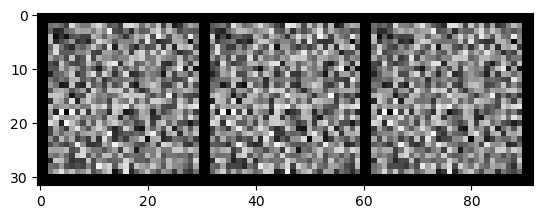

Starting epoch 125...
g_loss: 0.6511057019233704, d_loss: 1.3610221147537231


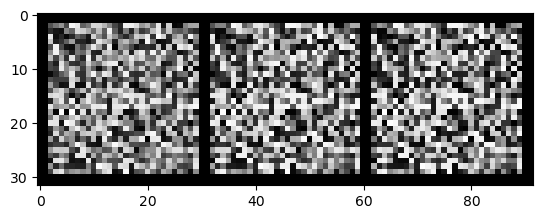

Starting epoch 126...
g_loss: 0.7384331822395325, d_loss: 1.408294916152954


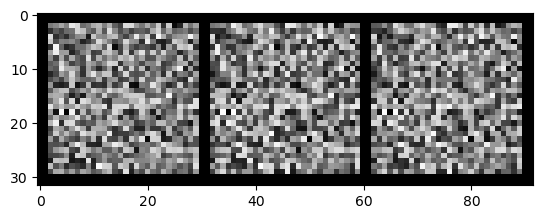

Starting epoch 127...
g_loss: 0.69709712266922, d_loss: 1.3699578046798706


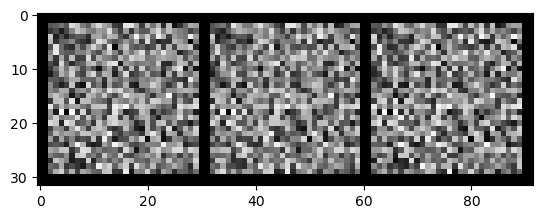

Starting epoch 128...
g_loss: 0.678320050239563, d_loss: 1.4009695053100586


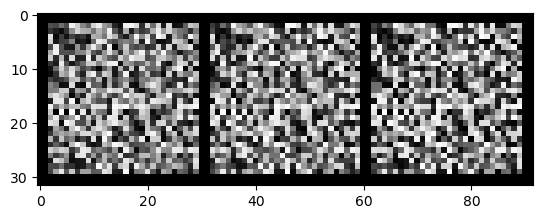

Starting epoch 129...
g_loss: 0.7227698564529419, d_loss: 1.3724637031555176


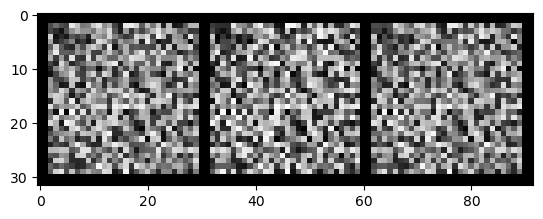

Starting epoch 130...
g_loss: 0.6943725347518921, d_loss: 1.365315318107605


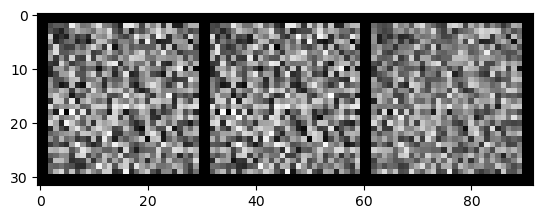

Starting epoch 131...
g_loss: 0.6797758340835571, d_loss: 1.3800225257873535


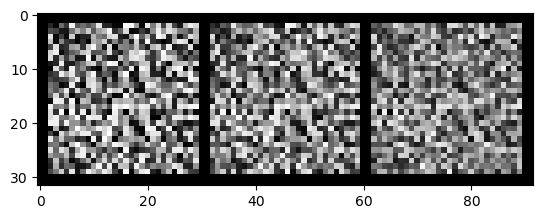

Starting epoch 132...
g_loss: 0.6964862942695618, d_loss: 1.3593106269836426


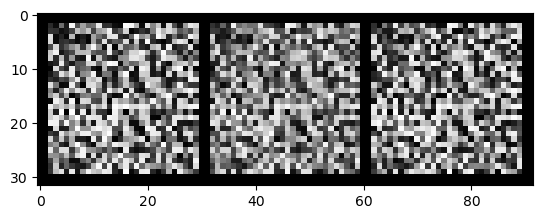

Starting epoch 133...
g_loss: 0.7119249701499939, d_loss: 1.3660483360290527


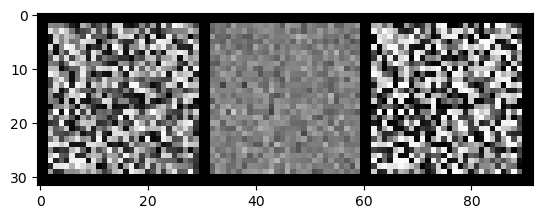

Starting epoch 134...
g_loss: 0.6850258111953735, d_loss: 1.3743698596954346


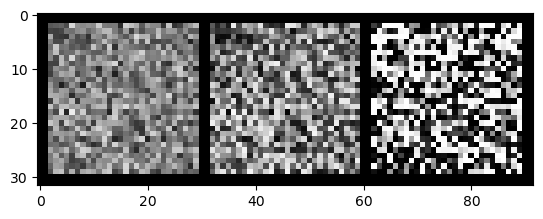

Starting epoch 135...
g_loss: 0.7031188607215881, d_loss: 1.3781182765960693


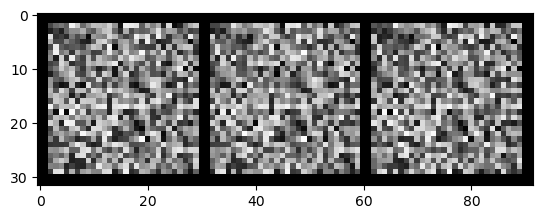

Starting epoch 136...
g_loss: 0.6932060122489929, d_loss: 1.4249749183654785


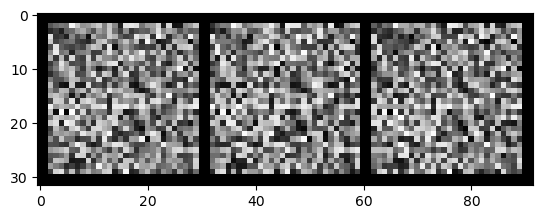

Starting epoch 137...
g_loss: 0.6922723650932312, d_loss: 1.38016676902771


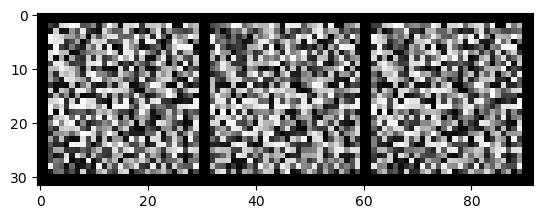

Starting epoch 138...
g_loss: 0.6819189190864563, d_loss: 1.3715813159942627


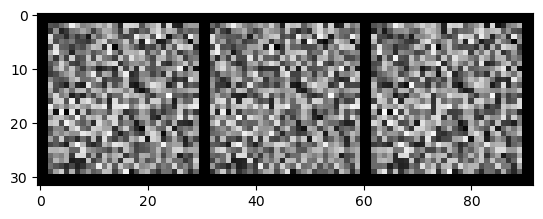

Starting epoch 139...
g_loss: 0.702868640422821, d_loss: 1.4158285856246948


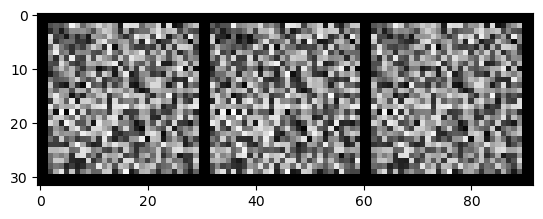

Starting epoch 140...
g_loss: 0.6723368763923645, d_loss: 1.3634881973266602


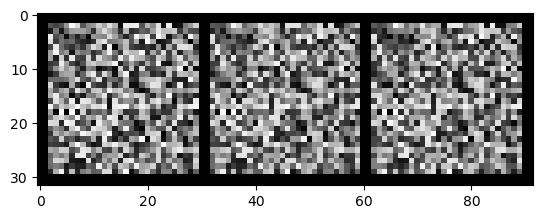

Starting epoch 141...
g_loss: 0.7470343112945557, d_loss: 1.391160488128662


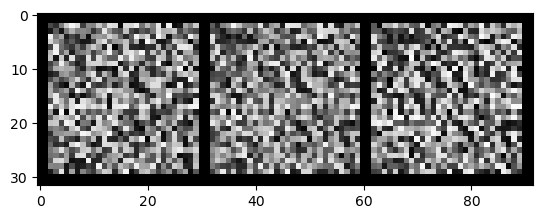

Starting epoch 142...
g_loss: 0.7316629886627197, d_loss: 1.382498860359192


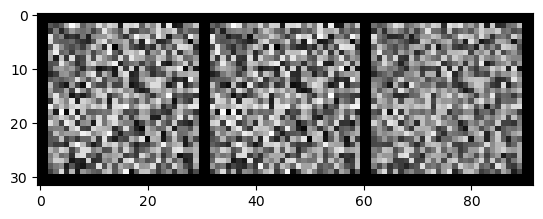

Starting epoch 143...
g_loss: 0.6777108311653137, d_loss: 1.3742514848709106


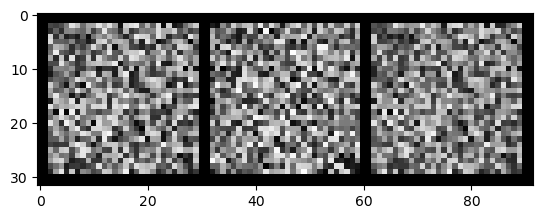

Starting epoch 144...
g_loss: 0.6667475700378418, d_loss: 1.3970277309417725


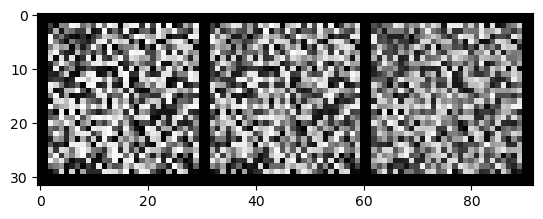

Starting epoch 145...
g_loss: 0.6964750289916992, d_loss: 1.3753108978271484


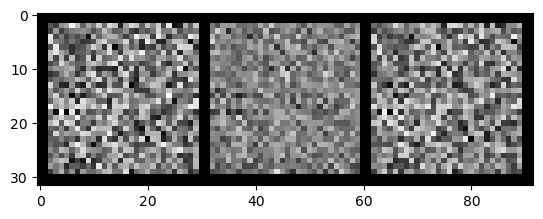

Starting epoch 146...
g_loss: 0.677239179611206, d_loss: 1.4110195636749268


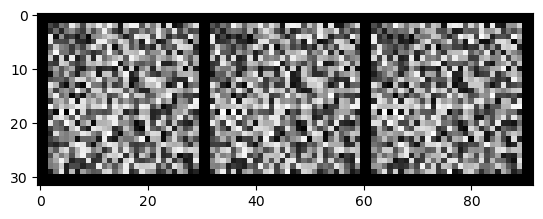

Starting epoch 147...
g_loss: 0.7004181146621704, d_loss: 1.358760952949524


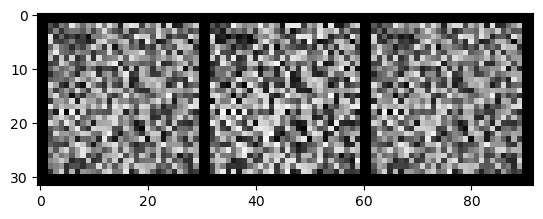

Starting epoch 148...


In [ ]:
for epoch in range(epochs):

    print('Starting epoch {}...'.format(epoch+1))

    for i, (images, labels) in enumerate(train_loader):

        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)

        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

        d_accuracy = calculate_discriminator_accuracy(discriminator, real_images, labels)

    # Set generator eval
    generator.eval()

    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    # Building z
    z = Variable(torch.randn(class_num-1, z_size)).to(device)

    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()